In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [107]:
PATH = Path('data/pascal')
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [5]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [11]:
annotations = pd.DataFrame(trn_j['annotations'])
images = pd.DataFrame(trn_j['images'])
categories = pd.DataFrame(trn_j['categories'])

In [ ]:
# {image_id: [(box coordinates, category_id),()]}

In [12]:
annotations.head()

,area,bbox,category_id,id,ignore,image_id,iscrowd,segmentation
0,34104,"[155, 96, 196, 174]",7,1,0,12,0,"[[155, 96, 155, 270, 351, 270, 351, 96]]"
1,13110,"[184, 61, 95, 138]",15,2,0,17,0,"[[184, 61, 184, 199, 279, 199, 279, 61]]"
2,81326,"[89, 77, 314, 259]",13,3,0,17,0,"[[89, 77, 89, 336, 403, 336, 403, 77]]"
3,64227,"[8, 229, 237, 271]",2,4,0,23,0,"[[8, 229, 8, 500, 245, 500, 245, 229]]"
4,29505,"[229, 219, 105, 281]",2,5,0,23,0,"[[229, 219, 229, 500, 334, 500, 334, 219]]"


In [13]:
images.head()

,file_name,height,id,width
0,000012.jpg,333,12,500
1,000017.jpg,364,17,480
2,000023.jpg,500,23,334
3,000026.jpg,333,26,500
4,000032.jpg,281,32,500


In [14]:
categories.head()

,id,name,supercategory
0,1,aeroplane,none
1,2,bicycle,none
2,3,bird,none
3,4,boat,none
4,5,bottle,none


In [16]:
data = (annotations
        .merge(images, how='left', left_on='image_id', right_on='id')
        .merge(categories, how='left', left_on='category_id', right_on='id'))
data.head()

,area,bbox,category_id,id_x,ignore,image_id,iscrowd,segmentation,file_name,height,id_y,width,id,name,supercategory
0,34104,"[155, 96, 196, 174]",7,1,0,12,0,"[[155, 96, 155, 270, 351, 270, 351, 96]]",000012.jpg,333,12,500,7,car,none
1,13110,"[184, 61, 95, 138]",15,2,0,17,0,"[[184, 61, 184, 199, 279, 199, 279, 61]]",000017.jpg,364,17,480,15,person,none
2,81326,"[89, 77, 314, 259]",13,3,0,17,0,"[[89, 77, 89, 336, 403, 336, 403, 77]]",000017.jpg,364,17,480,13,horse,none
3,64227,"[8, 229, 237, 271]",2,4,0,23,0,"[[8, 229, 8, 500, 245, 500, 245, 229]]",000023.jpg,500,23,334,2,bicycle,none
4,29505,"[229, 219, 105, 281]",2,5,0,23,0,"[[229, 219, 229, 500, 334, 500, 334, 219]]",000023.jpg,500,23,334,2,bicycle,none


In [52]:
# remove any ignore
# len(data) = 7844
data = data[data.ignore != 1]
len(data)

6301

In [21]:
# example of how to create the largest bounding box table from previous lesson

# largest_bbox = data.pivot_table(index='file_name', aggfunc='max', values='area').reset_index()
# largest_bbox = largest_bbox.merge(data[['area', 'bbox', 'image_id', 'file_name', 'name']], how='left')
# largest_bbox.head()

,file_name,area,bbox,image_id,name
0,000012.jpg,34104,"[155, 96, 196, 174]",12,car
1,000017.jpg,81326,"[89, 77, 314, 259]",17,horse
2,000023.jpg,111101,"[2, 1, 241, 461]",23,person
3,000026.jpg,21824,"[89, 124, 248, 88]",26,car
4,000032.jpg,28832,"[103, 77, 272, 106]",32,aeroplane


In [99]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [100]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

# Multi-label only

In [95]:
df = images[['file_name']].copy()

In [96]:
def bb_hw_pandas(x):
    return [x[1], x[0], x[1]+x[3]-1, x[0]+x[2]-1]

In [97]:
orig_boxes = []
diff_boxes = []
cats = []
for idx,r in df.iterrows():
    anno_rows = data.loc[data.file_name == r.file_name]
    boxes = anno_rows['bbox'].values.tolist()
    orig_boxes.append(boxes)
    diff_boxes.append([bb_hw_pandas(x) for x in boxes])
    cats.append(anno_rows['name'].values.tolist())
df['hw_boxes'] = orig_boxes
df['b_boxes'] = diff_boxes
df['cats'] = cats

In [101]:
multi_label_csv = PATH/'tmp/multi_label.csv'

In [104]:
df.to_csv(multi_label_csv, columns=['file_name', 'cats'], index=False)

In [106]:
f_model = resnet34
sz = 224
bs = 64

In [108]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, multi_label_csv, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

/Users/adamschiller/Projects/DeepLearning/fastai/courses/dl2/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [109]:
learn.lr_find()

A Jupyter Widget

epoch      trn_loss   val_loss   <lambda>                  
    0      0.859734   2.962457   0.892475  



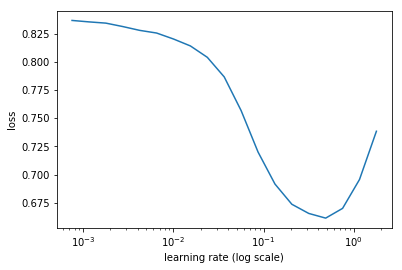

In [112]:
learn.sched.plot(n_skip_end=2)

In [117]:
lr = 8e-2

In [114]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

0.3

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [ ]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,5))

In [ ]:
learn.save('multi-label')

In [ ]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i]>0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()